In [44]:
!pip install polars astropy matplotlib seaborn umap-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 7.3 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import warnings
warnings.simplefilter(action='ignore')

import os
import umap
import numpy as np
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
import astropy
import seaborn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from collections import OrderedDict


from dataloader import LSSTSourceDataSet
from taxonomy import class_map

%matplotlib inline

In [3]:
# Get the mean wavlengths for each filter and then convert to micro meteres
wavelengths = {
    'u': (320 + 400) / (2 * 1000),
    'g': (400 + 552) / (2 * 1000),
    'r': (552 + 691) / (2 * 1000),
    'i': (691 + 818) / (2 * 1000),
    'z': (818 + 922) / (2 * 1000),
    'Y': (950 + 1080) / (2 * 1000),
}

In [4]:
anomaly_map = OrderedDict({
                'SNII-NMF': 'common',
                'SNIc-Templates': 'common',
                'CART': 'anomaly',
                'EB': 'common',
                'SNIc+HostXT_V19': 'common',
                'd-Sct': 'common',
                'SNIb-Templates': 'common',
                'SNIIb+HostXT_V19': 'common',
                'SNIcBL+HostXT_V19': 'common',
                'CLAGN': 'anomaly',
                'PISN': 'anomaly',
                'Cepheid': 'common',
                'TDE': 'common',
                'SNIa-91bg': 'common',
                'SLSN-I+host': 'common',
                'SNIIn-MOSFIT': 'common',
                'SNII+HostXT_V19': 'common',
                'SLSN-I_no_host': 'anomaly',
                'SNII-Templates': 'common',
                'SNIax': 'common',
                'SNIa-SALT3': 'common',
                'KN_K17': 'anomaly',
                'SNIIn+HostXT_V19': 'common',
                'dwarf-nova': 'common',
                'uLens-Binary': 'anomaly',
                'RRL': 'common',
                'Mdwarf-flare': 'common',
                'ILOT': 'anomaly',
                'KN_B19': 'anomaly',
                'uLens-Single-GenLens': 'anomaly',
                'SNIb+HostXT_V19': 'common',
                'uLens-Single_PyLIMA': 'anomaly'
            })

ap_map = OrderedDict({
    class_map[key]: anomaly_map[key] for key in anomaly_map
})

anom_classes = []
non_anom_classes = []
classes = []

for key in ap_map:
    classes.append(key)
    if ap_map[key] == 'anomaly':
        anom_classes.append(key)
    else:
        non_anom_classes.append(key)
        
    
    
print(ap_map, anom_classes, non_anom_classes, len(anom_classes) + len(non_anom_classes))

OrderedDict([('SNII', 'common'), ('SNIb/c', 'common'), ('CART', 'anomaly'), ('EB', 'common'), ('Delta Scuti', 'common'), ('AGN', 'anomaly'), ('PISN', 'anomaly'), ('Cepheid', 'common'), ('TDE', 'common'), ('SNI91bg', 'common'), ('SLSN', 'anomaly'), ('SNIax', 'common'), ('SNIa', 'common'), ('KN', 'anomaly'), ('Dwarf Novae', 'common'), ('uLens', 'anomaly'), ('RR Lyrae', 'common'), ('M-dwarf Flare', 'common'), ('ILOT', 'anomaly')]) ['CART', 'AGN', 'PISN', 'SLSN', 'KN', 'uLens', 'ILOT'] ['SNII', 'SNIb/c', 'EB', 'Delta Scuti', 'Cepheid', 'TDE', 'SNI91bg', 'SNIax', 'SNIa', 'Dwarf Novae', 'RR Lyrae', 'M-dwarf Flare'] 19


## Preprocess the Data (Skip if you stored the data already)
The preprocessing steps will create and save 3 arrays.

x_data: information for each light curve. Length of each entry should be the number of observations in that light curve. Each timestep should have the scaled time, scaled flux, scaled flux error, median passband wavelength

host_galaxy_info: Include any contextual information to this array. We will save 2 parameters: redshift and Milky Way extinction.

target: target class name for each light curve.

In [113]:
# Simple test to verify data loader
train_set = LSSTSourceDataSet('../ELAstiCC_data/test_parquet.parquet')

In [5]:
x_data = [] # info => for each time step, store time, median passband wavelength, flux, flux error
host_galaxy_info = [] # 2 numbers per time step: redshift and Milky Way extinction
target = [] # store target class

In [6]:
# Time window around trigger
before = 30
after = 70

n = train_set.__len__()

for i in range(n):
    
    print(f"Object {((i * 100)/n):.3f} %", end="\r")
    
    source = train_set.__getitem__(i)
    table = source.get_event_table()
    class_name = source.ELASTICC_class
    mw_ebv = table.meta['MWEBV']
    
    df = table
    df = pd.DataFrame(np.array(df)) # astropy table to pandas dataframe

    # ved-TODO: Add z back in, Get host galaxy info redshift and Milky Way extinction
    cur_meta = [mw_ebv]

    # Scale flux - We choose to scale the fluxes by 500 to make the values more manageable
    df['flux'] = (df['flux']) / 500
    df['fluxErr'] = (df['fluxErr']) / 500

    # Only keep observations within the time window
    # ved-CHANGED: changed to find trigger idx and time
    trigger_idx = df.index[df['photflag'] == 6144].tolist()[0]
    trigger_mjd = df['time'][trigger_idx] # CHANGE THIS IF TRIGGER IS NOT AT 0
    df = df[(df['time'] > trigger_mjd - before) & (df['time'] < trigger_mjd + after)] # Cut on time

    # Remove (empty) sufficiently small light curves
    if (len(df) == 0): 
        continue

    # ved-TODO: Add this back in after you have redshift. Correct for cosmological time dilation
    # df['time'] = df['time'] / (1 + data[id].meta['redshift'])

    # Sort by time
    df.sort_values("time", inplace=True) 
    df.drop('photflag', axis=1, inplace=True)

    # Scale times to be between 0 and 1
    df.time = (df.time - (-before)) / (after + before)

    # Map passband to median wavelength
    df['passband'] = df['passband'].map(wavelengths)

    # Store data
    x_data.append(np.array(df))
    target.append(class_name)
    host_galaxy_info.append(cur_meta)

In [22]:

def save(save_path , obj):
    with open(save_path, 'wb') as f:
        pickle.dump(obj, f)

In [7]:
# Save data


os.makedirs("processed", exist_ok=True)        
save("processed/target.pkl", target)
save("processed/x_data.pkl", x_data)
save("processed/host_galaxy_info.pkl", host_galaxy_info)
del train_set

## Restart here if data is saved.

In [5]:
# Load data

def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

target = load("processed/target.pkl")

# Converting the elasticc class to the astrophysical class
target = [class_map[e_class] for e_class in target]
x_data = load("processed/x_data.pkl")
host_galaxy_info = load("processed/host_galaxy_info.pkl")
print(np.unique(target), len(np.unique(target)))

['AGN' 'CART' 'Cepheid' 'Delta Scuti' 'Dwarf Novae' 'EB' 'ILOT' 'KN'
 'M-dwarf Flare' 'PISN' 'RR Lyrae' 'SLSN' 'SNI91bg' 'SNII' 'SNIa' 'SNIax'
 'SNIb/c' 'TDE' 'uLens'] 19


#### If you're here, you should have preprocessed data!

In [6]:
# Cuts number of objects to 13,000 transients max
np.random.seed(42)

target = np.array(target)

for class_name, counts in zip(*np.unique(target, return_counts=True)):
    # Remove the extra samples
    if counts > 13000:
        indices = np.where(target == class_name)[0]
        indices = np.random.choice(indices, counts - 13000, replace=False, )
        target = np.delete(target, indices)
        x_data = [x for i, x in enumerate(x_data) if i not in indices]
        host_galaxy_info = np.delete(host_galaxy_info, indices, axis=0)
np.unique(target, return_counts=True)

(array(['AGN', 'CART', 'Cepheid', 'Delta Scuti', 'Dwarf Novae', 'EB',
        'ILOT', 'KN', 'M-dwarf Flare', 'PISN', 'RR Lyrae', 'SLSN',
        'SNI91bg', 'SNII', 'SNIa', 'SNIax', 'SNIb/c', 'TDE', 'uLens'],
       dtype='<U13'),
 array([13000,  3517,  5901,  8849,  3439, 13000,  3197,  1896,   796,
        13000,  6014, 13000, 12272, 13000, 13000, 12012, 13000, 13000,
         7537]))

## Prepare arrays for Tensorflow

Typical Neural Networks require a fixed lenght input. However, Recurrent Neural Networks are capable of handling variable lengths, making them especially well-suited to time-series. However,  special, we can have a variable length. To use Tensorflow, we still need to provide a fixed length, but we can later using a Tensorflow Masking Layer to tell the RNN to ignore the extra time-steps later on. 

Let's find the maximum number of timesteps for any light curve in our dataset, and pad all light curves to that length

In [7]:
# Get number of observations for all light curves and get max number of timesteps 
lengths = []
for lc in x_data:
    lengths.append(len(lc))

ntimesteps = np.max(lengths)
print("Max timesteps is:", ntimesteps)

Max timesteps is: 146


In [8]:
# Pad for TF masking layer
for ind in range(len(x_data)):
    x_data[ind] = np.pad(x_data[ind], ((0, ntimesteps - len(x_data[ind])), (0, 0)))

In [9]:
# Split data into anomalous and normal classes and x inputs and y targets

y_data_anom = []
y_data_norm = []
x_data_norm = []
x_data_anom = []
host_gal_anom = []
host_gal = []

for i in range(len(target)):

    if (target[i] in anom_classes):
        x_data_anom.append(x_data[i])
        y_data_anom.append(target[i])
        host_gal_anom.append(host_galaxy_info[i])

    else:
        x_data_norm.append(x_data[i])
        y_data_norm.append(target[i])
        host_gal.append(host_galaxy_info[i])



In [10]:
# One-hot Encoding

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

y_data_norm = enc.fit_transform(np.array(y_data_norm).reshape(-1, 1)).todense()

ved_norm_encoding = enc.categories_
ved_norm_encoding

[array(['Cepheid', 'Delta Scuti', 'Dwarf Novae', 'EB', 'M-dwarf Flare',
        'RR Lyrae', 'SNI91bg', 'SNII', 'SNIa', 'SNIax', 'SNIb/c', 'TDE'],
       dtype='<U13')]

In [11]:
# Train-validation-test split: 80% training, 10% validation, 10% test 

X_train, X_test, host_gal_train, host_gal_test, y_train, y_test = train_test_split(x_data_norm, host_gal, y_data_norm, random_state = 40, test_size = 0.1)
X_train, X_val, host_gal_train, host_gal_val, y_train, y_val = train_test_split(X_train, host_gal_train, y_train, random_state = 40, test_size = 1/9)


In [12]:
# Get class_weights for imbalanced classes
class_weights = {i : 0 for i in range(y_train.shape[1])}

for value in y_train:
  class_weights[np.argmax(value)]+=1

for id in class_weights.keys():
  class_weights[id] = len(y_train) / class_weights[id]


class_weights

{0: 19.316501162053665,
 1: 12.929571489181162,
 2: 33.257548199345216,
 3: 8.766420558059258,
 4: 142.62870514820594,
 5: 18.928571428571427,
 6: 9.295882053889171,
 7: 8.823103647944412,
 8: 8.770625479662318,
 9: 9.504626260526042,
 10: 8.794247787610619,
 11: 8.8452979876161}

In [13]:
# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

host_gal_train = np.array(host_gal_train)
host_gal_test = np.array(host_gal_test)
host_gal_val = np.array(host_gal_val)

y_train = np.squeeze(y_train)
y_val = np.squeeze(y_val)
y_test = np.squeeze(y_test)
y_data_anom = np.squeeze(y_data_anom)

In [14]:
dummy = enc.transform(np.array(non_anom_classes).reshape(-1, 1))

ordered_class_names = non_anom_classes

In [15]:
# Generate Table for Training Counts

train_counts = {i : 0 for i in classes}

for i in y_train:
    train_counts[ordered_class_names[np.argmax(i)]] += 1
    
val_counts = {i : 0 for i in classes}

for i in y_val:
    val_counts[ordered_class_names[np.argmax(i)]] += 1
    
test_counts = {i : 0 for i in classes}

for i in y_test:
    test_counts[ordered_class_names[np.argmax(i)]] += 1

for i in y_data_anom:
    test_counts[i] += 1

In [16]:
full_data = {i: [] for i in classes}

for i in train_counts.keys():
    full_data[i].append(train_counts[i])
    
for i in val_counts.keys():
    full_data[i].append(val_counts[i])
    
for i in test_counts.keys():
    full_data[i].append(test_counts[i])

In [17]:
# Make Latex Table of counts for each training, validation, test, and all data (Table 1 in paper)
for key, value in full_data.items():
    print(f"{key} & {value[0]} & {value[1]} & {value[2]} & {value[1] + value[0] + value[2]} \\\\")
    print("\hline")


SNII & 4733 & 595 & 573 & 5901 \\
\hline
SNIb/c & 7071 & 910 & 868 & 8849 \\
\hline
CART & 0 & 0 & 3517 & 3517 \\
\hline
EB & 2749 & 322 & 368 & 3439 \\
\hline
Delta Scuti & 10429 & 1298 & 1273 & 13000 \\
\hline
AGN & 0 & 0 & 13000 & 13000 \\
\hline
PISN & 0 & 0 & 13000 & 13000 \\
\hline
Cepheid & 641 & 83 & 72 & 796 \\
\hline
TDE & 4830 & 595 & 589 & 6014 \\
\hline
SNI91bg & 9835 & 1211 & 1226 & 12272 \\
\hline
SLSN & 0 & 0 & 13000 & 13000 \\
\hline
SNIax & 10362 & 1313 & 1325 & 13000 \\
\hline
SNIa & 10424 & 1294 & 1282 & 13000 \\
\hline
KN & 0 & 0 & 1896 & 1896 \\
\hline
Dwarf Novae & 9619 & 1199 & 1194 & 12012 \\
\hline
uLens & 0 & 0 & 7537 & 7537 \\
\hline
RR Lyrae & 10396 & 1322 & 1282 & 13000 \\
\hline
M-dwarf Flare & 10336 & 1287 & 1377 & 13000 \\
\hline
ILOT & 0 & 0 & 3197 & 3197 \\
\hline


## Neural Network Classifier

Here, we develop a GRU RNN architecture. You can change this model to suit your classification

Function to make model. Here you'll need to design the architecture. You'll probably just need to change the input shape for the input layers (commented with CHANGE) depending on whether you use host galaxy information or not.

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Dense, Masking, concatenate, GRU
from tensorflow.keras.callbacks import EarlyStopping
from math import dist

def make_classifier_model(latent_size):

    num_classes = len(class_weights)
    n_features = 4

    input_1 = Input((ntimesteps, n_features), name='lc')  # X.shape = (Nobjects, Ntimesteps, 4) CHANGE

    masking_input1 = Masking(mask_value=0.)(input_1)

    lstm1 = GRU(100, return_sequences=True, activation='tanh')(masking_input1)
    lstm2 = GRU(100, return_sequences=False, activation='tanh')(lstm1)

    dense1 = Dense(100, activation='tanh')(lstm2)

    input_2 = Input(shape = (1, ), name='host') # CHANGE

    dense2 = Dense(10)(input_2)

    merge1 = concatenate([dense1, dense2])

    dense3 = Dense(100, activation='relu')(merge1)

    dense4 = Dense(latent_size, activation='relu', name='latent')(dense3)

    output = Dense(num_classes, activation='softmax')(dense4)

    model = keras.Model(inputs=[input_1, input_2], outputs=output)

    model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    return model

In [19]:
# Object to store a trained model. Has MCIF built in.

from tensorflow.keras import Model
from sklearn.ensemble import IsolationForest
class Trained_Model:
    def __init__(self, size, redshift):
        
        self.size = size
        self.redshift = redshift
            
        
        
        
    def load_model(self, path):
        ins = 'No' if not self.redshift else ''
        self.model=keras.models.load_model(f'Models/{path}')
        self.latent_model = Model(inputs=[self.model.get_layer('lc').input, self.model.get_layer('host').input], outputs=self.model.get_layer('latent').output)
        
        
    def _train_latent(self):
        print(self.host_gal_train.shape)
        self.train_latent = self.latent_model.predict([self.X_train, self.host_gal_train])
        
    def _test_latent(self):
        self.test_latent = self.latent_model.predict([self.X_test, self.host_gal_test])
        
    def _val_latent(self):
        self.val_latent = self.latent_model.predict([self.X_val, self.host_gal_val])
        
    def _anom_latent(self):
        self.anom_latent = self.latent_model.predict([self.X_anom, self.host_gal_anom])
    
    def initialize_mcif(self):

        self.iso_forests = []
        

        full_latent_data = [[] for i in range(12)]

        for i in range(len(self.train_latent)):
            full_latent_data[np.argmax(y_train[i])].append(self.train_latent[i])
            
        for i in range(len(self.val_latent)):
            full_latent_data[np.argmax(y_val[i])].append(self.val_latent[i])


        for i in range(12):
            self.iso_forests.append(IsolationForest(random_state=0, max_samples = 'auto', n_estimators=200).fit(np.array(full_latent_data[i])))

        # self.iso_forests.append(iso_forests)
        
        
    def score(self, x_data):
        scores = [-det.decision_function(x_data) for det in self.iso_forests]

        scores = np.array(scores)
        scores = scores.T
        return [np.min(i) for i in scores]
    
    def score_val(self):
        self.val_scores = self.score(self.val_latent)
        
    def score_test(self):
        self.test_scores = self.score(self.test_latent)
        
    def score_anom(self):
        self.anom_scores = self.score(self.anom_latent)
        
    def score_train(self):
        self.train_scores = self.score(self.train_latent)
            
        

In [20]:
y_train.shape

(91425, 12)

In [21]:
latent_size=9

In [ ]:
latent_size=9
model = make_classifier_model(latent_size) # HERE YOU CAN CHANGE THE LATENT SPACE SIZE

early_stopping = EarlyStopping(
                              patience=5,
                              min_delta=0.001,                               
                              monitor="val_loss",
                              restore_best_weights=True
                              )



try:
    history = model.fit(x = [X_train, host_gal_train], validation_data=([X_val, host_gal_val], y_val), y = y_train, epochs=40, batch_size = 128, class_weight = class_weights, callbacks=[early_stopping])
except Exception as e:
    print(e)
    pass

In [50]:
# Save
model.save(f"Models/RedshiftLatent_{latent_size}")
save(f"Models/RedshiftLatent_{latent_size}_history", history)

NameError: name 'model' is not defined

In [22]:
x_data_anom = np.array(x_data_anom)
host_gal_anom = np.array(host_gal_anom)

In [23]:
best = Trained_Model(latent_size, True)
# Load the model
best.load_model(f"RedshiftLatent_{latent_size}")


2024-04-19 14:48:51.501689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14777 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:15:00.0, compute capability: 7.0
2024-04-19 14:48:51.503197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14777 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:16:00.0, compute capability: 7.0
2024-04-19 14:48:53.182286: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2024-04-19 14:48:53.538895: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2024-04-19 14:48:53.837142: W tensorflow/core/com

In [24]:
# Calculate a lot of scores

best.train_latent = best.latent_model.predict([X_train, host_gal_train])
best.val_latent = best.latent_model.predict([X_val, host_gal_val])
best.initialize_mcif()
best.anom_latent = best.latent_model.predict([x_data_anom, host_gal_anom])

best.score_anom()
best.score_val()

best.test_predictions = best.model.predict([X_test, host_gal_test])

2024-04-19 14:48:57.637050: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000


358/358 [==============================] - 3s 4ms/step


In [25]:
best.test_latent = best.latent_model.predict([X_test, host_gal_test])
best.score_test()

358/358 [==============================] - 1s 4ms/step


In [26]:
non_anom_order = [ordered_class_names.index(c_name) for c_name in non_anom_classes]
# This is the order of indices that we want to generate plots for
# I.e. if the one-hot vector for SNIa has a 1 at position 9, then SNIa are actually the 9th class but we want it to be first. So non_anom_order[0] = 9

# Plot Generation

All these functions take in predictions, and nothings stopping them from being pre-trigger predictions, predictions 30 days post-trigger, etc.
To get the classifier's output for partial light curves, you'll need to create new X_test and x_data_anom and use the cut_curve function (defined a good bit below this block) to cut the light curve. You can see an example with x_data_pre 2 blocks below this.

In [27]:
# Have fixed colors per class
# Colors for plotting  
colors = ['r', 'g', 'y', 'b', 'purple', 'orange', 'gray', 'k', 'm', 'c', 'brown', 'olive']

color_from_class = {c_name : colors[ordered_class_names.index(c_name)] for c_name in non_anom_classes}
prop_cycle = plt.rcParams['axes.prop_cycle']
anom_colors = prop_cycle.by_key()['color']


for ind, c_name in enumerate(anom_classes):
    color_from_class[c_name] = anom_colors[ind]
    color_from_class[c_name] = anom_colors[ind]
    
color_from_class['All'] = 'grey'


In [28]:
import os
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import seaborn

# Matplotlib set up
font = {'size'   : 17}
matplotlib.rc('font', **font)    
colors = ['r', 'g', 'y', 'b', 'purple', 'orange', 'gray', 'k', 'm', 'c', 'brown', 'olive']

In [29]:
def to_order(output): # Converts from file_name to position in order
    return ordered_class_names[np.argmax(output)]


def saveplot(savepath): # Saves a plot (called in like every function)
    if (savepath):
        if ("UMAP" not in savepath):
            plt.savefig(savepath + '.pdf', bbox_inches='tight')
        else:
            plt.savefig(savepath + '.png', bbox_inches='tight')

def average_score(scores_maj, y_data_maj, scores_anom, y_data_anom, title="", savepath=None):
    '''
    Calculate the average anomaly score for each class.
    Input
    Scores and targets for both anomalous and majority classes
    '''
    total_counts = {i : 0 for i in classes}
    average_score = {i : 0 for i in classes}


    for i in range(len(y_data_maj)):

        total_counts[classes[to_order(y_data_maj[i])]] += 1
        average_score[classes[to_order(y_data_maj[i])]] += scores_maj[i]

    for i in range(len(y_data_anom)):
        total_counts[y_data_anom[i]] += 1
        average_score[y_data_anom[i]] += scores_anom[i]

    for key in total_counts.keys():
        if (total_counts[key] == 0):
            continue
        average_score[key] /= total_counts[key]

    fig, ax = plt.subplots(figsize=(13, 13))
    
    averages = list(average_score.values())

    cmap = matplotlib.cm.Blues(np.linspace(0,1,100))
    cmap = matplotlib.colors.ListedColormap(cmap[25:75,:-1])

    im = ax.imshow([averages], cmap=cmap)

    ax.set_yticks([])
    ax.set_xticks(range(len(averages)), list(average_score.keys()), fontsize=15, rotation=45)
    for x in range(len(averages)):
      ax.annotate(str(round(averages[x], 2)), xy=(x, 0),
                  horizontalalignment='center',
                  verticalalignment='center', fontsize=15, fontweight = "bold" if (x > len(np.unique(y_data_maj))) else "normal") # Change the condition for something being anomalous
    ax.set_title(title, fontsize=20)
    saveplot(savepath)

def median_score(scores_maj, y_data_maj, scores_anom, y_data_anom, title="", savepath=None): # Literally the same thing but just the median now
    # total_counts = {i : 0 for i in classes}
    score_dist = {i : [] for i in classes}


    for i in range(len(y_data_maj)):
        score_dist[classes[to_order(y_data_maj[i])]].append(scores_maj[i])

    for i in range(len(y_data_anom)):
        score_dist[y_data_anom[i]].append(scores_anom[i])

    for key in score_dist.keys():
        score_dist[key] = np.median(score_dist[key])

    fig, ax = plt.subplots(figsize=(13, 13))
    
    averages = list(score_dist.values())

    cmap = matplotlib.cm.Blues(np.linspace(0,1,100))
    cmap = matplotlib.colors.ListedColormap(cmap[25:75,:-1])

    im = ax.imshow([averages], cmap=cmap)

    ax.set_yticks([])
    ax.set_xticks(range(len(averages)), list(score_dist.keys()), fontsize=15, rotation=45)
    for x in range(len(averages)):
      ax.annotate(str(round(averages[x], 2)), xy=(x, 0),
                  horizontalalignment='center',
                  verticalalignment='center', fontsize=15, fontweight = "bold" if (x > 11) else "normal")
    ax.set_title(title, fontsize=20)
    saveplot(savepath)

    
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(predictions, labels, savepath=None): # Confusion Matrix plot, predictions is a list of probabilities
    
    single_pred = np.array([to_order(i) for i in predictions])
    single_test = np.array([to_order(i) for i in labels])

    cm = confusion_matrix(single_test, single_pred, labels = range(len(non_anom_classes)), normalize='true')

    disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm, 2), display_labels=[c_name for c_name in non_anom_classes]) # CHANGE DISPLAY LABELS

    disp.plot(cmap=plt.cm.Blues)

    fig = disp.figure_


    disp.im_.colorbar.remove()

    fig.set_figwidth(10)
    fig.set_figheight(10)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.xticks(rotation=90)

    plt.xlabel("True Class", fontsize=29)
    plt.ylabel("Predicted Class", fontsize=29)
    # plt.title("Confusion Matrix on Full Time Series", fontsize=27)
    
    saveplot(savepath)

    
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, auc


def plot_roc_curve(predictions, labels, savepath=None): # Same as confusion matrix
    

    single_test = np.array([np.argmax(i) for i in labels])
    plt.figure(figsize=(10, 10))

    for i in non_anom_order:
      fpr, tpr, _ = roc_curve(y_true = single_test, y_score = predictions[:, i], pos_label = i)
      plt.plot(fpr, tpr, label = ved_norm_encoding[0][i] + f" ({round(auc(fpr, tpr), 2)})", color=colors[i])

    plt.legend(loc=0, fontsize=21)

    # plt.title("ROC Curve for Pre-Trigger Light Curve", fontsize=28)

    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
    
    #saveplot(savepath)
    

array(['CART', 'CART', 'CART', ..., 'uLens', 'uLens', 'uLens'],
      dtype='<U13')

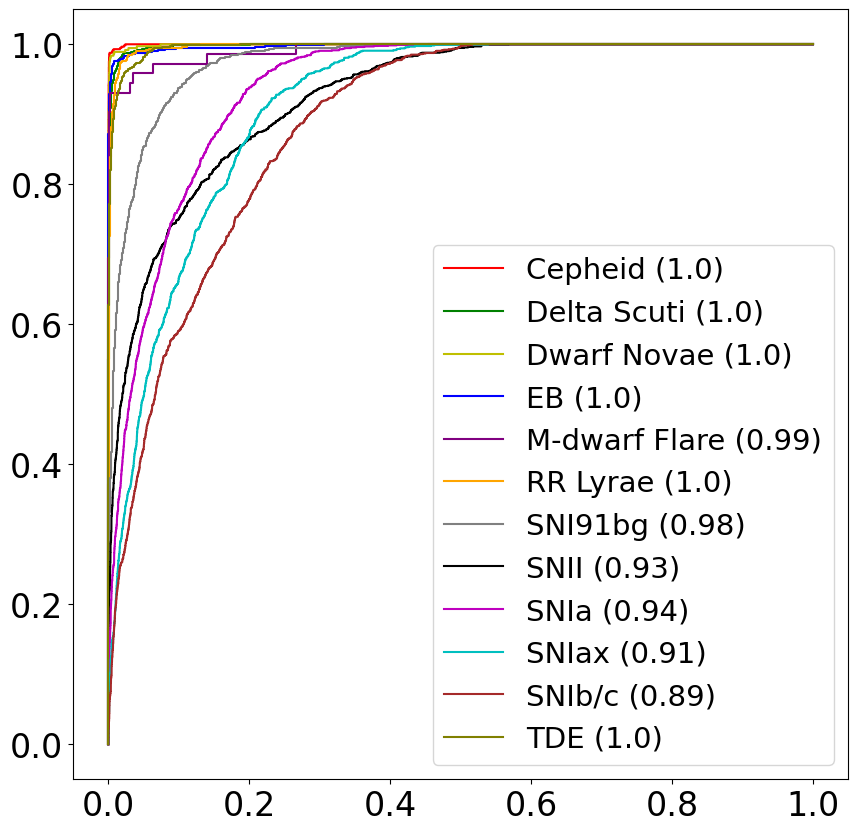

In [30]:
# matplotlib.style.set('defualt')
plot_roc_curve(best.test_predictions, y_test, savepath='last/ROCCurvePreNoTitle')
target

['Cepheid' 'Delta Scuti' 'Dwarf Novae' 'EB' 'M-dwarf Flare' 'RR Lyrae'
 'SNI91bg' 'SNII' 'SNIa' 'SNIax' 'SNIb/c' 'TDE']


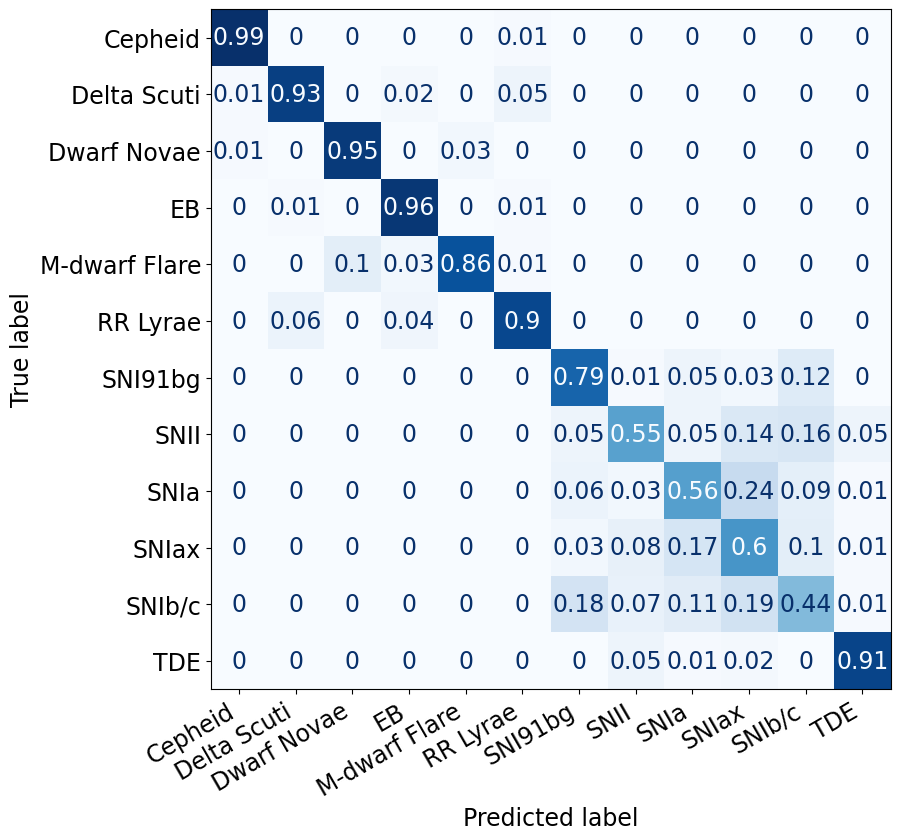

In [31]:
font = {'size'   : 17}

matplotlib.rc('font', **font)
#plot_confusion_matrix(best.test_predictions, y_test, savepath='last/ConfusionMatrix')

ved_pred = []
ved_true = []

print(ved_norm_encoding[0])

for i in range(y_test.shape[0]):
    a = int(np.argmax(best.test_predictions[i, :]))
    b = int(np.argmax(y_test[i, :]))
    ved_pred.append(ved_norm_encoding[0][a])
    ved_true.append(ved_norm_encoding[0][b])
    
    
cm = confusion_matrix(ved_true, ved_pred, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm, 2), display_labels = ved_norm_encoding[0]) # CHANGE DISPLAY LABELS

disp.plot(cmap=plt.cm.Blues)

fig = disp.figure_
fig.autofmt_xdate()


disp.im_.colorbar.remove()

fig.set_figwidth(10)
fig.set_figheight(10)


Here we generate the precision-recall curve, calculate precision and recall as defined in the paper

In [32]:
from sklearn.metrics import auc

def get_pr(minority, majority): # takes minority and majority data and gets the precision-recall with minority being True Positive and majority being False Positive

    precision = []
    recall = []
    thresholds = []
    minority=np.array(minority)
    majority=np.array(majority)
    for threshold in np.arange(min(np.min(minority),np.min(majority)), max(np.max(minority),np.max(majority)) + 0.002, 0.001):
        ta = np.count_nonzero(minority > threshold)
        fa = np.count_nonzero(majority > threshold)
        tn = np.count_nonzero(majority < threshold)
        fn = np.count_nonzero(minority < threshold)
        if fn == 0 or fa == 0:
          continue
        if (ta + fa == 0):
            continue
        recall.append(ta / (ta + fn))
        precision.append(ta / (ta + fa))
        thresholds.append(threshold)
    return thresholds, precision, recall

def get_pr_auc(scores_maj, y_data_maj, scores_anom, y_data_anom): # Gets PR AUC, not actually used anywhere
    np.random.seed(60)
    
    aucs = {}
    
    for ind, i in enumerate(non_anom_classes):
        
        mult_iso_maj_class = [scores_maj[t] for t in range(len(scores_maj)) if non_anom_classes[np.argmax(y_data_maj[t])] == i]

        mult_iso_min_cur = np.random.choice(scores_anom, int(len(mult_iso_maj_class)), p=p_anom)

        thresholds, precision, recall = get_pr(mult_iso_maj_class, mult_iso_min_cur)

        aucs[i] = auc(recall, precision)


    for ind, i in enumerate(anom_classes):
        mult_iso_min_class = [scores_anom[t] for t in range(len(y_data_anom)) if y_data_anom[t] == i] # all anomalies of current class (i)

        mult_iso_min_class = np.random.choice(mult_iso_min_class, int(min(len(scores_maj), len(mult_iso_min_class))))

        thresholds, precision, recall = get_pr(mult_iso_min_class, scores_maj)

        aucs[i] = auc(recall, precision)

        
    return aucs

IMPORTANT NOTE: RANDOM SUBSAMPLES

Because a lot of the reported results rely on sampling a random subsample, I created the arrays p_norm and p_anom. These *rig* the probability of each transient being chosen randomly so that transients represented less frequently have a higher probability. This ensures an evenly sampled distribution. E.g. if we have 100 SNIa and 200 SNIIb in our majority sample, I still want the probability of choosing each to be the same.

However you might want an uneven population distribution, in which case you can make p_anom and p_norm have all the same value or remove them when they are used.

In [33]:
import matplotlib.gridspec as gridspec

class_weights_anom = {i: 0 for i in anom_classes}

p_norm = [class_weights[np.argmax(i)] for i in y_test]
sum = np.sum(p_norm)
for i in range(len(p_norm)):
  p_norm[i] /= sum



for i in y_data_anom:
  class_weights_anom[i]+=1

print(class_weights_anom)
for i in list(class_weights_anom.keys()):
  class_weights_anom[i] = len(y_data_anom) / class_weights_anom[i]


p_anom = [class_weights_anom[i] for i in y_data_anom]

sum = np.sum(p_anom)

for i in range(len(p_anom)):
  p_anom[i] /= sum


title_sz=17

# This function plots the precision recall curve
def plot_pr_anom(scores_maj, y_data_maj, scores_anom, y_data_anom, s=None):
    
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1,2,0], height_ratios=[1,1], wspace=0.3)

    ax3 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax3)
    ax = fig.add_subplot(gs[:, 1:3])

    ax.set_aspect('equal', 'box')
    
    plt.ylim((0, 1))
    plt.xlim((0, 1))
    l = 3 # Linewidth
    
    for ind, i in enumerate(anom_classes):
        mult_iso_min_class = [scores_anom[t] for t in range(len(scores_anom)) if y_data_anom[t] == i] # all anomalies of current class (i)

        mult_iso_min_class = np.random.choice(mult_iso_min_class, int(min(len(scores_maj), len(mult_iso_min_class)))) # Subset of these anomalies because we have less testing data

        thresholds, precision, recall = get_pr(mult_iso_min_class, scores_maj)
        ax.plot(recall, precision, label=f"{i} ({round(auc(recall, precision), 2)})", c = color_from_class[i], linewidth=l)

        ax2.plot(thresholds, recall, label=f"{i}", c = color_from_class[i], linewidth=l)

        ax3.plot(thresholds, precision, label=f"{i}", c = color_from_class[i], linewidth=l)

    # Majority classes, defined below

    thresholds, precision, recall = plot_pr_maj(scores_maj, y_data_maj, scores_anom, y_data_anom)

    ax.plot(recall, precision, label=f"Common Classes ({round(auc(recall, precision), 2)})", c = 'grey', linewidth=l)

    ax2.plot(thresholds, recall, label=f"Common Classes", c = 'grey', linewidth=l)

    ax3.plot(thresholds, precision, label=f"Common Classes", c = 'grey', linewidth=l)


    ax.set_ylabel("Precision", fontsize=title_sz)
    ax.set_xlabel("Recall", fontsize=title_sz)
    ax.legend(fontsize=22)

    ax2.set_ylabel("Recall", fontsize=title_sz)
    ax2.set_xlabel("Threshold", fontsize=title_sz)
    # ax2.legend(fontsize=15)

    ax3.set_ylabel("Precision", fontsize=title_sz)
    ax3.set_xlabel("Threshold", fontsize=title_sz)
    # ax3.legend(fontsize=15)

    fig.suptitle("Anomaly Precision-Recall Curve", fontsize=33)
    ax.set_xticks(np.arange(0.2, 1.2, 0.2))


    #saveplot(s)

def plot_pr_maj(scores_maj, y_data_maj, scores_anom, y_data_anom, s=None): # Returns precision/recall for majority classes. Not plotted

    
    mult_iso_maj_class = [scores_maj[t] for t in range(len(scores_maj))]
    mult_iso_maj_class = np.random.choice(mult_iso_maj_class, 10000, p=p_norm)

    mult_iso_min_cur = np.random.choice(scores_anom, int(len(mult_iso_maj_class)), p=p_anom)

    thresholds, precision, recall = get_pr(mult_iso_maj_class, mult_iso_min_cur)


    return thresholds, precision, recall



{'CART': 3517, 'AGN': 13000, 'PISN': 13000, 'SLSN': 13000, 'KN': 1896, 'uLens': 7537, 'ILOT': 3197}


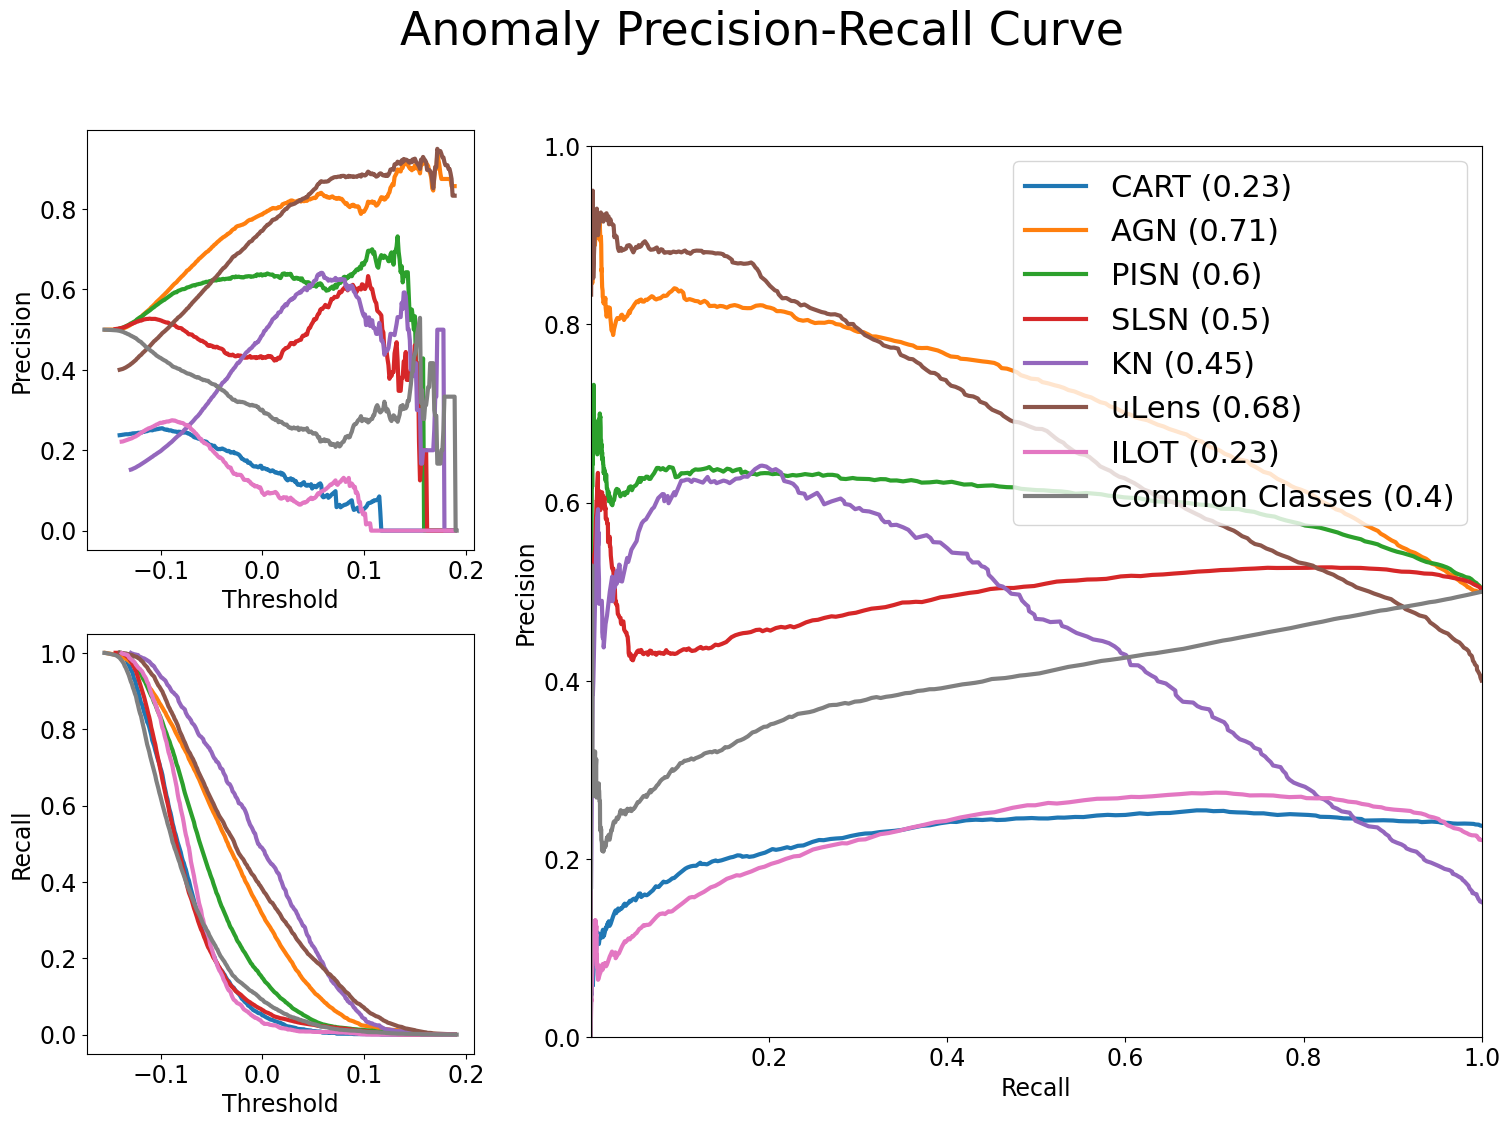

In [34]:
plot_pr_anom(best.test_scores, y_test, best.anom_scores, y_data_anom, s="last/PRAnom")

In [63]:
# Distribution of Anomaly Scores

import seaborn as sns

file_to_index = {x: classes.index(x) for x in classes}
def plot_dist(scores_maj, y_data_maj, scores_anom, y_data_anom, savepath=None): # Same input as average/median_score
    
    color = ['#ADD8E6', '#ADD8E6', '#FF6645', '#ADD8E6', '#ADD8E6', '#FF6645', '#FF6645', '#ADD8E6', '#ADD8E6', '#ADD8E6', '#FF6645', '#ADD8E6', '#ADD8E6', '#FF6645', '#ADD8E6', '#FF6645', '#ADD8E6', '#ADD8E6', '#FF6645']
    print(len(color))
    for c in ordered_class_names:
        print(c)
        if c in anom_classes:
            color.append('#FF6645')
        elif c in non_anom_classes:
            color.append('#ADD8E6')
    
    x=[]
    g=[]

    for i in range(len(scores_maj)):
        g.append(ordered_class_names[np.argmax(y_data_maj[i])])
        x.append(scores_maj[i])

    for i in range(len(scores_anom)):
        g.append(y_data_anom[i])
        x.append(scores_anom[i])

    df = pd.DataFrame(dict(x=x, g=g))

    df.sort_values('g', inplace=True, key=lambda x: x.map(file_to_index))

    

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    # Initialize the FacetGrid object
    g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=color)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "x",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping, but we do color = 'blue'
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "x")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.set(xlabel="Anomaly Score")

    g.despine(bottom=True, left=True)

    if (savepath):
        g.figure.savefig(f"{savepath}.pdf", bbox_inches='tight')

19
SNII
SNIb/c
EB
Delta Scuti
Cepheid
TDE
SNI91bg
SNIax
SNIa
Dwarf Novae
RR Lyrae
M-dwarf Flare


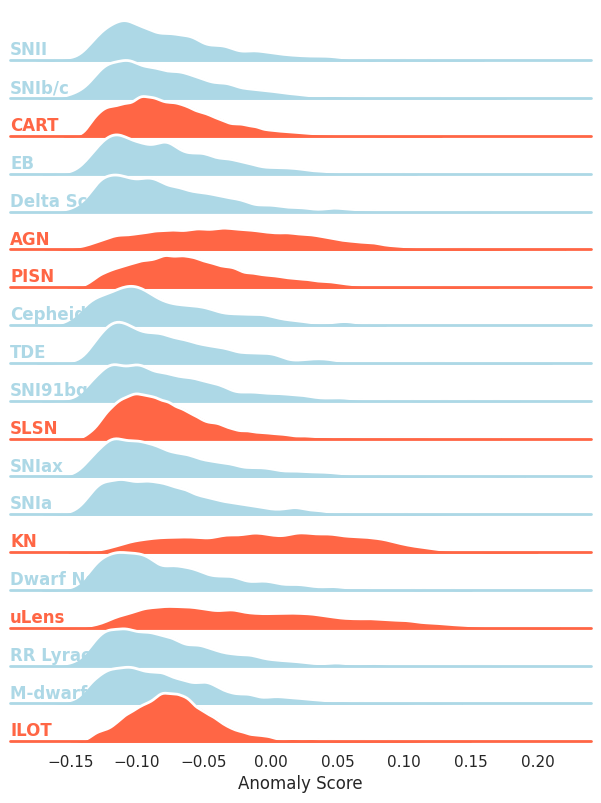

In [64]:
plot_dist(best.test_scores, y_val, best.anom_scores, y_data_anom)

In [37]:
# Randomly create subsamples and plot
all_counts = {}
from copy import deepcopy
def plot_recall(majority, minority, s=None, seed=100): # USE DEFAULT SEED! :)
    np.random.seed(seed)

    k = 50

    pref_counts = {}
    pref_recall = {}
    freqs = {}
    for key in ['All'] + anom_classes:
        pref_counts[key] = []
        pref_recall[key] = []
        freqs[key] = []

    for i in ordered_class_names:
        freqs[i] = []
    
    
    rigged_p_anom = p_anom.copy()

    # Uncomment to remove CaRTs

    # for i in range(len(p_anom)):
    #     if y_data_anom[i] == class_to_file['CaRT']:
    #         rigged_p_anom[i] = 0

    # sm = np.sum(rigged_p_anom)
    # for i in range(len(rigged_p_anom)):
    #     rigged_p_anom[i] /= sm


    
    for _ in range(k):

      freq = {i : 0 for i in pref_counts.keys()}
      for i in ordered_class_names:
          freq[i] = 0

      random_sample_maj = majority
   
    
      min_mask = np.random.choice(range(len(minority)), int(len(majority)/220), p = rigged_p_anom) # Change /220 for different ratio
      random_sample_min = np.array(minority)[min_mask]
      min_classes = np.array(y_data_anom)[min_mask]
        
      # print(len(random_sample_maj), len(random_sample_min))

      full_sample = [(i, ordered_class_names[np.argmax(y_test[ind])]) for ind, i in enumerate(random_sample_maj)] + [(i, min_classes[ind]) for ind, i in enumerate((random_sample_min))]
      full_sample = list(reversed(sorted(full_sample)))

      pref_sample = {i : [0] for i in anom_classes}
      pref_sample['All'] = [0]

     
      for i in full_sample:
        freq['All'] += 1
        pref_sample['All'].append(pref_sample['All'][-1] + (i[1] in anom_classes))
        
        for key in anom_classes:
           if (i[1] == key):
               freq[key] += 1
           pref_sample[key].append(pref_sample[key][-1] + (i[1] == key))

        for key in ordered_class_names:
            if (i[1] == key):
               freq[key] += 1

      prefr_sample = deepcopy(pref_sample)
      for i in pref_sample.keys():
          prefr_sample[i] = np.array(pref_sample[i]) / freq[i]
          # assert(np.max(prefr_sample[i]) <= 1)

        
      for key in pref_sample.keys():
          pref_counts[key].append(pref_sample[key])
          pref_recall[key].append(prefr_sample[key])
          freqs[key].append(freq[key])

      for key in ordered_class_names:
          freqs[key].append(freq[key])
          

    for i in freqs.keys():
        print(i, np.mean(freqs[i]), np.std(freqs[i]))

        all_counts[i]=freqs[i]
    # return
            
    final = []
            
    for key, value in pref_counts.items():
      med = []
      dev = []

      medr = []
      devr = []
        
        
      pref_counts = np.array(value).T
      rec_here = np.array(pref_recall[key]).T

      for i in range(len(pref_counts)):
        pref_counts[i] = np.array(pref_counts[i])
        rec_here[i] = np.array(rec_here[i])

        # assert(np.max(rec_here[i]) <= 1)
        # if (key == 'All'):
        #     print(i, pref_sample[key][i])
        med.append(np.mean(pref_counts[i]))
        dev.append(np.std(pref_counts[i]))

        medr.append(np.mean(rec_here[i]))
        devr.append(np.std(rec_here[i]))


      
      med=np.array(med)
      dev = np.array(dev)

      medr=np.array(medr)
      devr = np.array(devr)

      # print(np.max(medr + devr))
      
      final.append([med, dev, key, medr, devr])

    
    font = {'size'   : 17}

    matplotlib.rc('font', **font)
    
    fig, ax = plt.subplots()

    

    ax.set_xlim(0, 2000)
    ax.set_xlabel("Index (Top 2000 Scores)", fontsize=18)
    ax.set_ylabel("Recall", fontsize=18)

    ax.set_title("Anomalies Detected by Index", fontsize=21)

    ax2 = ax.twinx()

    ax2.set_ylabel('Detected Anomalies', fontsize=16)
    
    ind = 0

    # Comment if you don't want guessing line
    x = np.array(range(0,2000))
    y = 1/220 * x
    plt.plot(x, y, label='Guessing', linestyle='dashed', color='grey')

   
    
    for med, dev, label, medr, devr in final:
        if (label != 'All'): # running this loop through with 'All' plots result for all classes
            
            continue
 
        if label == 'All':
            ax.plot(medr, label=label if label != 'All' else 'This Work', color=color_from_class[label])
            ax.fill_between(range(1, len(med) + 1), medr + devr, medr-devr, alpha = 0.2, color=color_from_class[label])
        else:
            ax2.plot(range(1, len(med) + 1), med, label=label if label != 'All' else 'This Work', color = u'#ff7f0e') # color=color_from_class[label])
            ax2.fill_between(range(1, len(med) + 1), med + dev, med-dev, alpha = 0.2, color = u'#ff7f0e')# , color=color_from_class[abel])

    
    
    ax2.set_ylim(-0.1 * int(len(majority) / 220), 1.1 * int(len(majority) / 220))
    ax.set_ylim(-0.1, 1.1)

    
    ax.tick_params(axis='y')
    
    
    plt.legend(fontsize=14)

    plt.tight_layout()

    #saveplot(s)

All 11480.0 0.0
CART 7.66 2.687824399026097
AGN 7.68 2.3953287874527787
PISN 7.28 2.172924296886571
SLSN 6.9 2.6095976701399777
KN 7.62 2.2261176967986214
uLens 6.72 2.332723729891733
ILOT 7.14 2.7785607785326563
SNII 573.0 0.0
SNIb/c 868.0 0.0
EB 368.0 0.0
Delta Scuti 1273.0 0.0
Cepheid 72.0 0.0
TDE 589.0 0.0
SNI91bg 1226.0 0.0
SNIax 1325.0 0.0
SNIa 1282.0 0.0
Dwarf Novae 1194.0 0.0
RR Lyrae 1282.0 0.0
M-dwarf Flare 1377.0 0.0


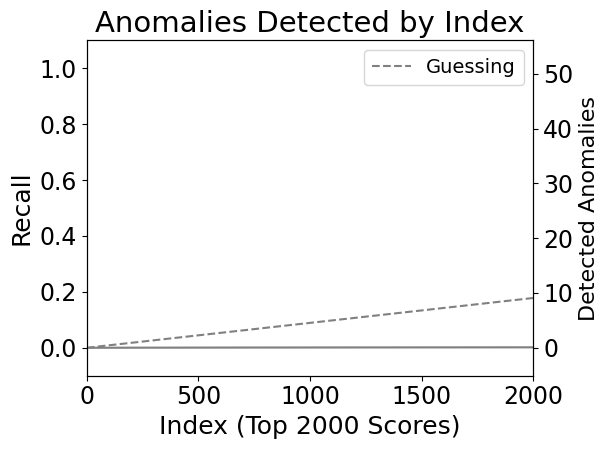

In [38]:
plt.style.use('default')
plot_recall(best.test_scores, best.anom_scores, s='last/AnomByInd')


In [39]:

for i_ in anom_classes:
    i=i_
    print(i, int(np.mean(all_counts[i])), "\pm", int(np.std(all_counts[i])))


CART 7 \pm 2
AGN 7 \pm 2
PISN 7 \pm 2
SLSN 6 \pm 2
KN 7 \pm 2
uLens 6 \pm 2
ILOT 7 \pm 2


In [40]:
latent_size=9
def plot_history(filepath, s= None):
    hist = load(filepath) 
    
    plt.plot(range(1, len(hist.history['val_accuracy']) + 1), hist.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(range(1, len(hist.history['accuracy']) + 1), np.array(hist.history['accuracy']), label='Training Accuracy') #  * len(X_val) /  len(X_train)
    
    plt.xlabel("Epoch", fontsize=17)
    plt.ylabel("Accuracy", fontsize=17)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    
    plt.legend(fontsize=14)
    
    # plt.title('Training/Validation Accuracy', fontsize=19)
    #saveplot(s)

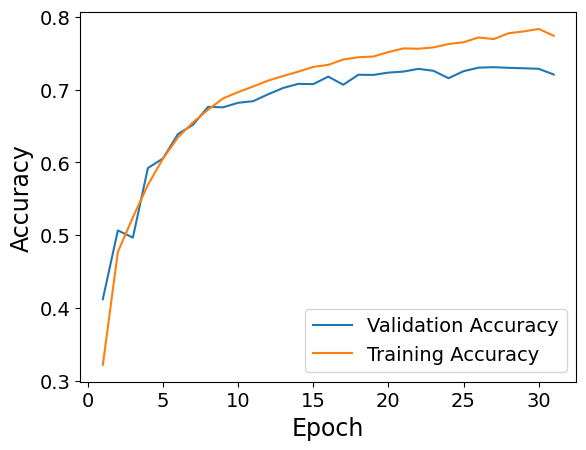

In [41]:
matplotlib.style.use('default')

plot_history(f'Models/RedshiftLatent_{latent_size}_history', s = 'last/AccuracyHistory')

In [48]:
# Get UMAP reducer and plot UMAP


def get_reducer(data): # Basic function
    reducer = umap.UMAP(random_state=5, min_dist=0.5, n_neighbors=500)

    reducer.fit(data)
    
    embedding=reducer.transform(data)
    
    return reducer, embedding
    
def plot_umap(embedding, labels, legend, uni=None, title='', savepath='', color=colors): # This is very specific to my dataset, I'd reccomending writing your own code if you want to see the UMAP reduction
    plt.figure(figsize=(10, 10))
    if uni == None:
        uni = np.unique(labels)

    print(uni)
    for cc, i in enumerate(uni):
        
        e=[]
        for ind, point in enumerate(labels):
            # print(point)
            if point == i:
                e.append(embedding[ind])
        
        assert(not len(e) == 0)
        e = np.array(e)
        if (type(i) == int):
            plt.scatter(e[:, 0], e[:, 1], label=non_anom_classes[i], c=color_from_class[non_anom_classes[i]]) # if cc != 0 else 'grey'
        elif (i in anom_classes):
            plt.scatter(e[:, 0], e[:, 1], label=i, c=color_from_class[i]) # if cc != 0 else 'grey'
        else:
            plt.scatter(e[:, 0], e[:, 1], label=i, c="Grey") # if cc != 0 else 'grey'

        
        
    plt.title(title, fontsize=27)
    # plt.xlabel('Arbritary Units', fontsize=17)
    # plt.ylabel('Arbritary Units', fontsize=17)
    plt.xticks(range(-5, 25, 5))
    plt.yticks(range(-5, 25, 5))
    
    plt.xlabel('UMAP 1', fontsize=17)
    plt.ylabel('UMAP 2', fontsize=17)
    plt.legend(fontsize=17,loc="upper right")
    #saveplot(savepath)
    
    # return reducer

In [43]:
import umap
best.te_reducer, best.te_embedding = get_reducer(best.test_latent)

In [44]:
best.tr_reducer, best.tr_embedding = get_reducer(best.train_latent)
best.a_reducer, best.a_embedding = get_reducer(best.anom_latent)
# best.te_reducer, best.te_embedding = get_reducer(best.test_latent)

In [45]:
save("FINALFINAL", best)

'best)' was not found in history, as a file, url, nor in the user namespace.


In [46]:
best = load("FINALFINAL")

FileNotFoundError: [Errno 2] No such file or directory: 'FINALFINAL'

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


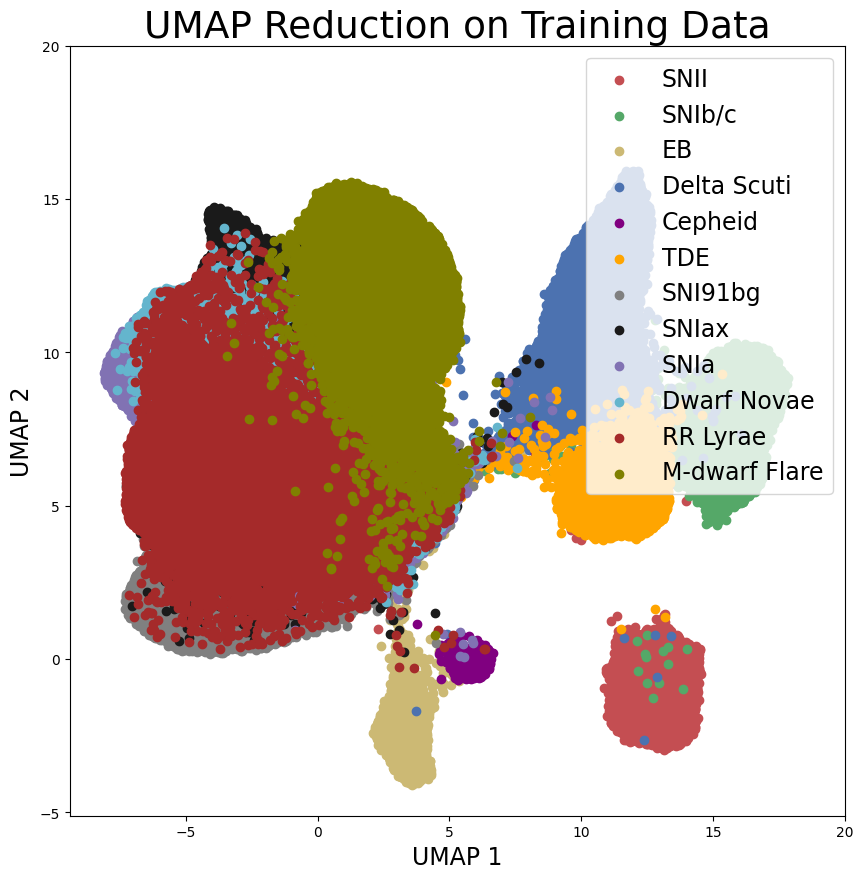

In [49]:

plot_umap(best.tr_embedding, [np.argmax(i) for i in y_train], [i for i in non_anom_classes], uni = [ordered_class_names.index(i) for i in non_anom_classes], title = "UMAP Reduction on Training Data", savepath="last/UMAPTrain")

['AGN' 'CART' 'ILOT' 'KN' 'PISN' 'SLSN' 'uLens']


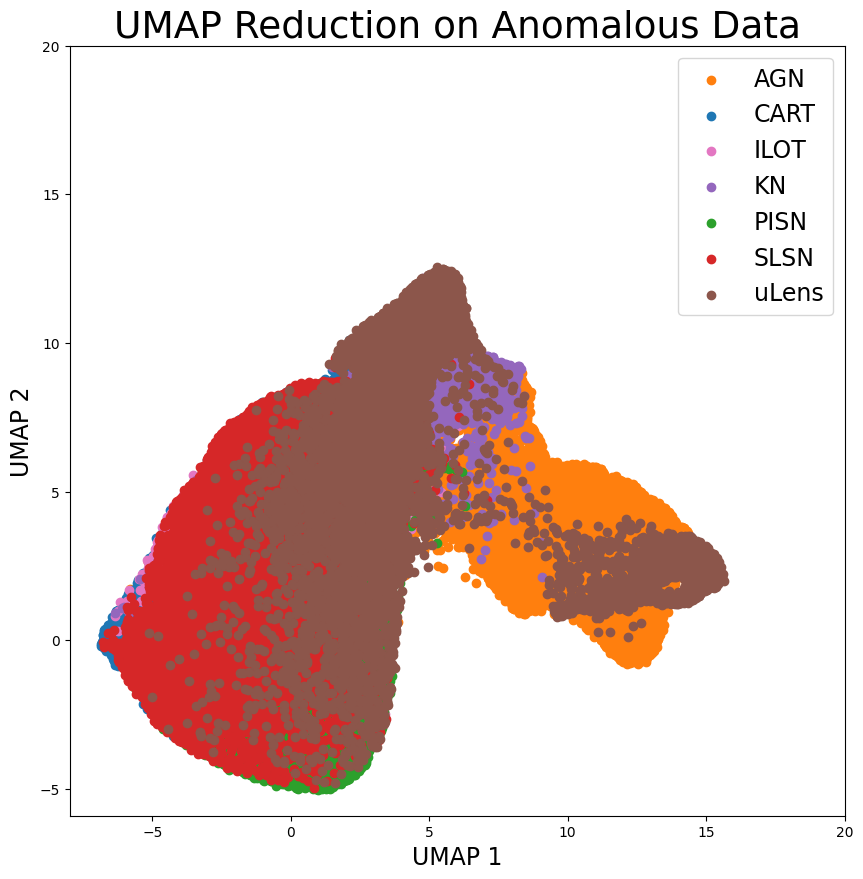

In [50]:
plot_umap(best.a_embedding, y_data_anom, [i for i in reversed(np.unique(y_data_anom))], title="UMAP Reduction on Anomalous Data", savepath="last/UMAPAnom")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


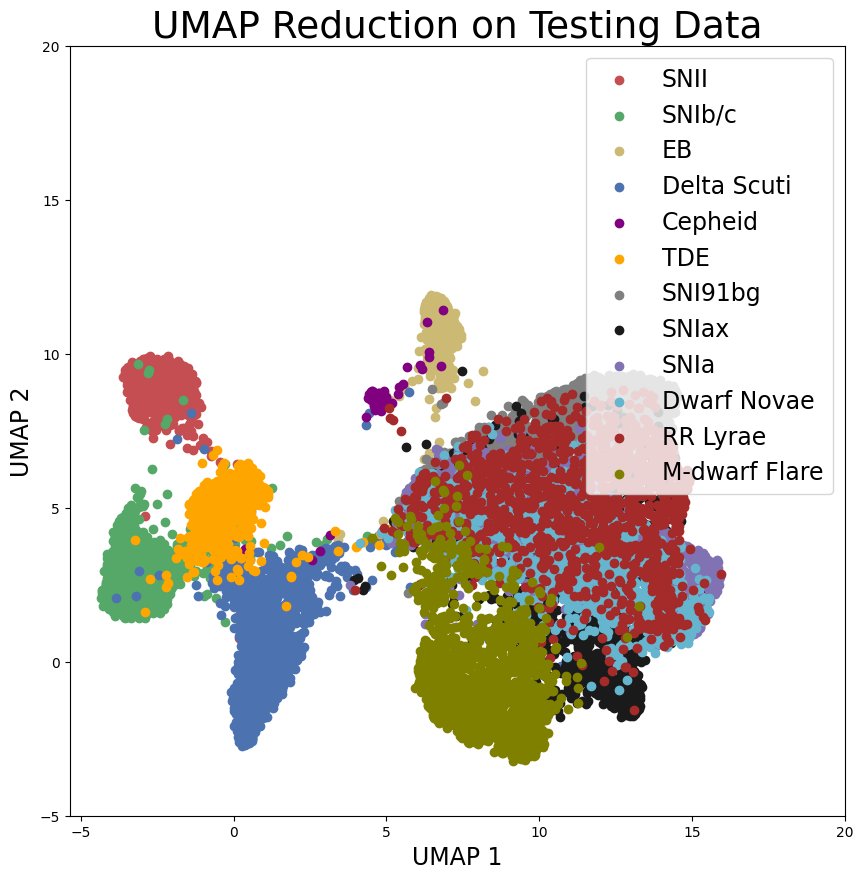

In [51]:
plot_umap(best.te_embedding, [np.argmax(i) for i in y_test], ordered_class_names, uni = [ordered_class_names.index(i) for i in non_anom_classes], title="UMAP Reduction on Testing Data", savepath="last/UMAPTest")

['AGN' 'CART' 'Common Transients' 'ILOT' 'KN' 'PISN' 'SLSN' 'uLens']


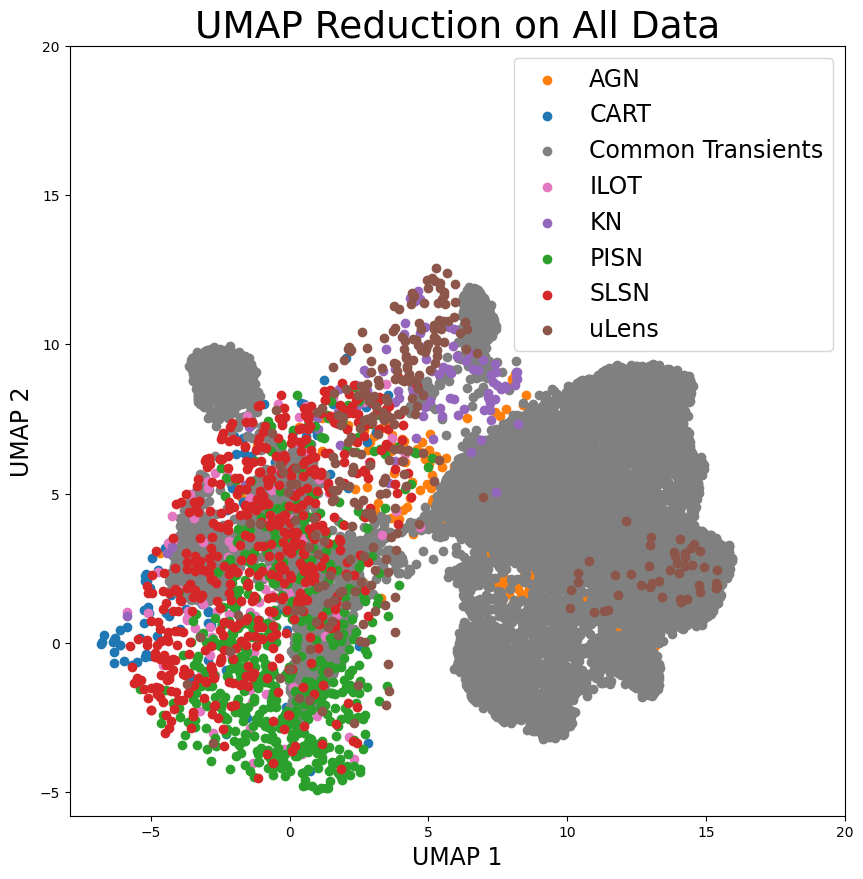

In [53]:
idx = np.random.choice(np.arange(len(best.a_embedding)), round(len(best.te_embedding)/5), replace=False)
vals = best.a_embedding[idx]
labels = np.array(y_data_anom)[idx]

plot_umap(np.append(best.te_embedding, vals, axis=0), ['Common Transients' for i in y_test] + list(labels), ['Common Transients'] + [i for i in np.unique(labels)], title="UMAP Reduction on All Data", savepath="last/UMAPAll")

In [54]:
save("FinalTrainedModel", best)

'best)' was not found in history, as a file, url, nor in the user namespace.


In [55]:
def cut_curve(lc, cutoff, ind=False): # assumes scaled cutoff and uses binary search
  # print(lc.shape)
  lo = 0
  hi = len(lc)-1

  while (lo < hi):
    m = (lo + hi)//2
    # print(lc[m][1], cutoff)
    if (lc[m][1] > cutoff or not np.any(lc[m][1])):
      hi = m
    else:
      lo = m+1

  # print(lo)
  
  if (not ind):
      for i in range(hi, len(lc)):
        if (not np.any(lc[i])):
          break
    
        lc[i] = np.zeros(4)

  if (not ind):
    return lc
  else:
    if (not np.any(lc[hi])):
        hi-=1
    return hi

In [56]:
# Real Time Results

# Redefine p_anom and p_norm

p_norm = [class_weights[np.argmax(i)] for i in y_test]

sum = np.sum(p_norm)

for i in range(len(p_norm)):
  p_norm[i] /= sum

class_weights_anom = {i: 0 for i in anom_classes}

for i in y_data_anom:
  class_weights_anom[i]+=1

print(class_weights_anom)
for i in list(class_weights_anom.keys()):
  class_weights_anom[i] = len(y_data_anom) / class_weights_anom[i]

p_anom = [class_weights_anom[i] for i in y_data_anom]


sum = np.sum(p_anom)

for i in range(len(p_anom)):
  p_anom[i] /= sum




def get_anomaly_real_time(curves, host_galaxy, inds, model): # get real time scores for the indices inds. Inputs are curves and host_galaxy
    # print('d')
    splits = []
    lcs = []
    host_gals = []
    for ind in inds:
        cur = np.zeros((ntimesteps, 4))
        anomaly_scores = []
        host_gal = np.array(host_galaxy[ind])
        curve = curves[ind]
        
        for ind, i in enumerate(curve):
            if (np.count_nonzero(i) == 0):
                break
            cur[ind]=i

            lcs.append(cur.copy())
            host_gals.append(host_gal)
    
        splits.append(len(lcs))

    lcs = np.array(lcs)
    host_gals = np.array(host_gals)

    scores = model.score(model.latent_model.predict([np.array(lcs), np.array(host_gals)]))
    
    ans = []
    prv=0
    for diff in splits:
        ans.append(scores[prv:diff])
        prv=diff
    return ans

def plot_real_median(X_test, x_data_anom, model, savepath="", classes=classes):
    
    # assert(len(norm_scores) == len(anom_scores) and len(norm_scores) == 200)
    
    norm_median = []
    norm_deviation = []
    
    class_median = {i: [] for i in non_anom_classes}
    class_deviation = {i: [] for i in non_anom_classes}


    cutoffs = list(range(-30, 71, 1))

    for t in cutoffs:
      cur_class = {i : [] for i in non_anom_classes} # list of scores for each class at this cutoff
        
      cur_values = []
      for ind in range(len(normal_inds)):

        cutoff = cut_curve(np.copy(X_test[normal_inds[ind]]), (t+30)/100, ind=True)

        # if (X_test[normal_inds[ind]][cutoff][1] <= (t+30-5)/100):
        #   continue
        cur_values.append(norm_scores[ind][min(cutoff, len(norm_scores[ind])-1)])
        
        cur_class[ordered_class_names[np.argmax(y_test[normal_inds[ind]])]].append(norm_scores[ind][min(cutoff, len(norm_scores[ind])-1)])
        
      for c in non_anom_classes:
        # if (t == 0):
            # print(np.mean(cur_class[c]))
        # print(c, t, len(cur_class[c]))
        cur_class[c] = np.array(cur_class[c])
        class_median[c].append(np.median(cur_class[c]))
        class_deviation[c].append(np.median(np.absolute(cur_class[c] - np.median(cur_class[c]))))

      cur_values=np.array(cur_values)

      norm_median.append(np.median(cur_values))
      norm_deviation.append(np.median(np.absolute(cur_values - np.median(cur_values))))

    norm_median = np.array(norm_median)
    norm_deviation = np.array(norm_deviation)

    fig, ax = plt.subplots(figsize=(8, 8))

    for class_ in non_anom_classes:
        class_median[class_] = np.array(class_median[class_])
        class_deviation[class_] = np.array(class_deviation[class_])

        if (class_ in classes):
            ax.plot(cutoffs, class_median[class_], '-', label=class_, color=color_from_class[class_])
            ax.fill_between(cutoffs, class_median[class_] - class_deviation[class_], class_median[class_] + class_deviation[class_], alpha=0.2, color=color_from_class[class_])



    plt.legend()
    # return
    

    # Remove if you don't want majority aggregate
    maj_col = u'grey'
    ax.plot(cutoffs, norm_median, '-', label="Common Classes", color=maj_col)
    ax.fill_between(cutoffs, norm_median - norm_deviation, norm_median + norm_deviation, alpha=0.2, color=maj_col)
    # ax.plot(cutoffs, norm_median, 'o', color=maj_col)


    anom_median = []
    anom_deviation = []

    class_median = {i: [] for i in anom_classes}
    class_deviation = {i: [] for i in anom_classes}

    class_flux = {i : [] for i in anom_classes}
    class_flux_dev = {i : [] for i in anom_classes}

    for t in cutoffs:

      cur_values = []
      cur_class = {i : [] for i in anom_classes}
      cur_flux = {i : [] for i in anom_classes}
      for ind in range(len(anom_inds)):
        cutoff = cut_curve(np.copy(x_data_anom[anom_inds[ind]]), (t+30)/100, ind=True)

        
        cur_values.append(anom_scores[ind][min(cutoff, len(anom_scores[ind])-1)])
        
        cur_class[y_data_anom[anom_inds[ind]]].append(anom_scores[ind][min(cutoff, len(anom_scores[ind])-1)])
          
        cur_flux[y_data_anom[anom_inds[ind]]].append(x_data_anom[ind][min(cutoff, len(anom_scores[ind])-1)])
        
      for c in anom_classes:

        cur_class[c] = np.array(cur_class[c])
        class_median[c].append(np.median(cur_class[c]))
        class_deviation[c].append(np.median(np.absolute(cur_class[c] - np.median(cur_class[c]))))

        cur_flux[c] = np.array(cur_flux[c])
        class_flux[c].append(np.median(cur_flux[c]))
        class_flux_dev[c].append(np.median(np.absolute(cur_flux[c] - np.median(cur_flux[c]))))

      cur_values=np.array(cur_values)

      anom_median.append(np.median(cur_values))
      anom_deviation.append(np.median(np.absolute(cur_values - np.median(cur_values))))

    anom_median = np.array(anom_median)
    anom_deviation = np.array(anom_deviation)

    # Remove this if you don't want anomalous aggregate
    ax.plot(cutoffs, anom_median, '-', label="Anomalous", color=u'#ff7f0e')
    ax.fill_between(cutoffs, anom_median - anom_deviation, anom_median + anom_deviation, alpha=0.2, color=u'#ff7f0e')

    
    for ind, c in enumerate(anom_classes):
        if (c not in classes and c not in classes):
            continue

    
        ax.plot(cutoffs, class_median[c], '-', label=c,  color=color_from_class[c])
        ax.fill_between(cutoffs, np.array(class_median[c]) - np.array(class_deviation[c]), np.array(class_median[c]) + np.array(class_deviation[c]), alpha=0.2,  color=color_from_class[c])

    ax.set_xlabel("Time", fontsize=25)
    ax.set_ylabel("Median Anomaly Score", fontsize=25)
    ax.legend(fontsize=16)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(-0.1, 0.1)
    

    # ax.set_title("Median Anomaly Score Over Time", fontsize=28)
    # plt.show()
    saveplot(savepath)

{'CART': 3517, 'AGN': 13000, 'PISN': 13000, 'SLSN': 13000, 'KN': 1896, 'uLens': 7537, 'ILOT': 3197}


In [57]:
# Get the random sample of inds/scores

normal_inds = np.random.choice(list(range(len(X_test))), 2000, p=p_norm, replace=False)
anom_inds = np.random.choice(list(range(len(x_data_anom))), 2000, p = p_anom, replace=False)

anom_scores = get_anomaly_real_time(x_data_anom, host_gal_anom, anom_inds, best)

norm_scores = get_anomaly_real_time(X_test, host_gal_test, normal_inds, best)

2725/2725 [==============================] - 8s 3ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FileNotFoundError: [Errno 2] No such file or directory: 'last/AnomScale.pdf'

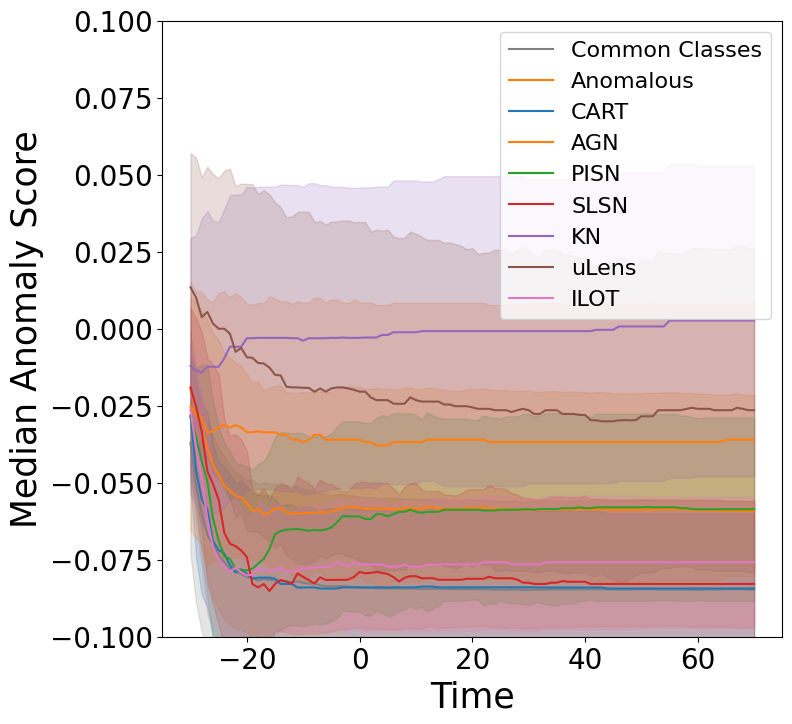

In [58]:
plt.style.use('default')

# plot_real_median(X_test, x_data_anom, best, "last/MajScale", ['SNIa', 'SNIIn', 'SLSN-I', 'KNe'])
plot_real_median(X_test, x_data_anom, best, "last/AnomScale", anom_classes) # ['SNIa', 'SNIIn', 'SLSN-I', 'KNe']

In [ ]:
plot_real_median(X_test, x_data_anom, best, "last/AllScale", [])

#### The following 2 codeblocks are really just for debugging. Use them for sample usage of the plot_real_time function (which is defined 3 blocks below)

In [ ]:
# Debug

ind = 100
import random
x_data_div = x_data_anom.copy()

    
cnt = 0
while True:

    if (y_data_anom[ind] == 'uLens-BSR'):
        plot_real_time(get_anomaly_real_time(x_data_div, host_gal_anom, [ind], best)[0], x_data_div[ind], y_data_anom[ind])

        if (cnt == 10):
            break
        
        
    ind+=1


In [ ]:
# DEBUG
import random
ind = 0

cnt = 0
while True:

    if (ordered_class_names[np.argmax(y_test[ind])] == 'SNIa'):
        cnt += 1
        if (cnt == 10):
            break

        plot_real_time(get_anomaly_real_time(X_test, np.zeros((len(X_test), 2)), [ind], best)[0], X_test[ind], ordered_class_names[np.argmax(y_test[ind])])

    ind+=1

In [ ]:
def plot_real_time(classification_scores, curve, class_):
    cur = np.array([(j[1] * 100) - 30 for j in curve])
    assert(not np.any(curve[len(classification_scores)]))
    cur = cur[:len(classification_scores)]
 
    r_band = []
    rer = []
    r_cur = []
    g_band = []
    ger = []
    g_cur = []

    for i in curve[:len(classification_scores)]:
        if (i[0] < 0.5):
            r_band.append(i[2])
            rer.append(i[3])
            r_cur.append((i[1] * 100) - 30)

        else:
            g_band.append(i[2])
            ger.append(i[3])
            g_cur.append((i[1] * 100) - 30)





    fig, axs = plt.subplots(2, figsize=(10, 20))

    plt.subplots_adjust(wspace=0, hspace=0)

    axs[0].set_title(f"Real Time Anomaly Score for a {class_}", fontsize=30)


    axs[0].set_ylabel('Scaled Flux', fontsize=27)
    axs[0].errorbar(r_cur, r_band, yerr=rer, fmt='.', label= 'r band')
    axs[0].errorbar(g_cur, g_band, yerr = ger, fmt = '.', label= 'g band')


    axs[1].set_ylabel('Anomaly Score', fontsize=27)
    axs[1].set_xlabel('Time Since Trigger', fontsize=27)
    axs[1].plot(cur, classification_scores)

    axs[1].set_ylim(-0.3, 0.3)
    axs[1].set_yticks(ticks=np.arange(-0.3, 0.3, 0.1))

    axs[0].tick_params(axis='both', labelsize=27)
    axs[1].tick_params(axis='both', labelsize=27)
    

    
    

    # axs[1].axhline(0.05, linestyle='--', color='r')

    axs[1].legend()
    plt.axvline(0, linestyle='--', color='r')

    saveplot(f"NewEx/{class_}Example{random.randint(1, 1000)}")
    plt.show()

    

### The next part is only there to produce a pretty plot for the paper :). I would ignore it

In [ ]:
inds = {
    "SNIa": 0,
    "SNIa-91bg": 11598,
    "SNIax":24800,
    "SNIb":43171,
    "SNIc":48450,
    "SNIc-BL":50052,
    "SNII":51471,
    "SNIIn":78884,
    "SNIIb":97091,
    "TDE":109392,
    "SLSN-I":120754,
    "AGN":138142,
    "CaRT":144631,
    "KNe":154531,
    "PISN":166504,
    "ILOT":177026,
    "uLens-BSR":187880
}

In [ ]:
# Finding good examples
from sklearn.preprocessing import MinMaxScaler

# fig, axs = plt.subplots(1, 2, figsize=(20, 30), sharey=True)
# fig.subplots_adjust(hspace=0)


done = {i : False for i in file_names}

def plot_curves(name, num = 100):

    band_medians = {'r' : 0.4827, 'g' : 0.6223}
    cnt = 0

    for ind in range(len(x_data)):

        if (target[ind] == name and cut_curve(x_data[ind], 1, ind=True) > 55 and host_galaxy_info[ind][0] < 0.5):
            
            maxi = np.max(x_data[ind][:, 2])
            mini = np.min(x_data[ind][:, 2])
            x_data[ind][:, 2] = (x_data[ind][:, 2] - mini) / (maxi - mini)
            x_data[ind][:, 3] /= (maxi - mini)

            done[target[ind]] = True
            cnt += 1


            red = x_data[ind][x_data[ind][:, 0] == band_medians['r']]
            green = x_data[ind][x_data[ind][:, 0] == band_medians['g']]
            plt.errorbar(red[:, 1], ((red[:, 2] + 30) * 100), fmt='^', alpha=0.3, color = colors[file_names.index(target[ind]) % len(colors)])
            plt.errorbar(green[:, 1], ((green[:, 2] + 30) * 100), fmt='o', alpha=1, color = colors[file_names.index(target[ind])  % len(colors)])

            # axs[int(cnt > 8)].errorbar(new_vals[:, 1] * 100 - 30, new_vals[:, 2] + prv_mx, fmt='o', color = colors[file_names.index(target[ind]) % len(colors)])
            # plt.text(0, prv_mx + x_data[0][2] + 0.5, target[ind], fontsize=20, color = colors[file_names.index(target[ind]) % len(colors)])

            # prv_mx += np.max(new_vals[:, 2]) + 0.5

            
            plt.ylabel('Scaled Flux + Offset', fontsize=15)
            plt.xlabel('Time Since Trigger', fontsize=15)
            plt.title(str(ind))
            
            plt.show()

        if (cnt == 100):
            break
    
    # plt.title('Sample Light Curves')
    # plt.ylim(-1, 29)
    # saveplot("Figures/samplecurves")
    
plot_curves(class_to_file['uLens-BSR'])

In [ ]:
interesting_inds = list(inds.values()) # [6, 13024, 26037, 39092, 44415, 45914, 47312, 60322, 73318, 85658, 97110, 114369, 120846, 130758, 144661, 153253, 164107]

In [ ]:
class_to_file = {v: k for k, v in classes}

In [ ]:
for i in range(len(x_data)):
    if (target[i] == 'SNIa'):
        plot_curve(x_data[i])
        break

In [ ]:

from sklearn.preprocessing import MinMaxScaler


plt.figure(figsize=(10, 40))
# fig, axs = plt.subplots(1, 2, figsize=(20, 30), sharey=True)
# fig.subplots_adjust(hspace=0)


done = {i : False for i in file_names}



band_medians = {'r' : 0.4827, 'g' : 0.6223}
prv_mx = 0
cnt = 0

for ind in reversed(interesting_inds): # [6, 13024, 26037, 39092, 44415, 45914, 47312, 60322, 73318, 97110, 85658, 114369, 130758, 144661, 153253, 164107, 120846]:
    # print(ind)
    maxi = np.max(x_data[ind][:, 2])
    mini = np.min(x_data[ind][:, 2])
    x_data[ind][:, 2] = (x_data[ind][:, 2] - mini) / (maxi - mini)
    x_data[ind][:, 3] /= (maxi - mini)

    done[target[ind]] = True
    cnt += 1
    if (cnt >= 10):
        break

    red = x_data[ind][x_data[ind][:, 0] == band_medians['r']]
    green = x_data[ind][x_data[ind][:, 0] == band_medians['g']]
    plt.errorbar((red[:, 1]) * 100 - 30, red[:, 2] + prv_mx, fmt='^', alpha=0.3, color = color_from_class[target[ind]])
    plt.errorbar((green[:, 1]) * 100 - 30, green[:, 2] + prv_mx, fmt='o', alpha=1, color = color_from_class[target[ind]])

    # axs[int(cnt > 8)].errorbar(new_vals[:, 1] * 100 - 30, new_vals[:, 2] + prv_mx, fmt='o', color = colors[file_names.index(target[ind]) % len(colors)])
    plt.text(5, prv_mx + 0.5, target[ind] + "        ", fontsize=25, color = color_from_class[target[ind]], ha='right', va='bottom')

    prv_mx += 1.2

        
plt.ylabel('Scaled Flux + Offset', fontsize=25)
plt.xlabel('Time Since Trigger', fontsize=25)

# plt.title('Sample Light Curves')
# plt.ylim(-1, 29)
saveplot("last/samplecurves2")

 # Testing with a Single Isolation Forest

In [ ]:
# recalculate class weights

class_weights = {i : 0 for i in range(y_train.shape[1])}

for value in y_train:
  class_weights[np.argmax(value)]+=1

for value in y_val:
  class_weights[np.argmax(value)]+=1

for id in class_weights.keys():
  class_weights[id] = (len(y_train) + len(y_val)) / class_weights[id]

sample_weights = [class_weights[np.argmax(i)] for i in y_train] + [class_weights[np.argmax(i)] for i in y_val]

from sklearn.ensemble import IsolationForest

best.iforest = IsolationForest(random_state=0, max_samples = 'auto', n_estimators=200).fit(np.append(best.train_latent, best.val_latent, axis=0), sample_weight=sample_weights)



In [ ]:
best.single_scores = -best.iforest.decision_function(best.test_latent)
best.single_scores_anom = -best.iforest.decision_function(best.anom_latent)

In [ ]:
# average_score(best.single_scores, y_test, best.single_scores_anom, y_data_anom, title="Average Anomaly Score\n(Single Isolation Forest)", savepath="FiguresNew/AverageScoreSingle")
median_score(best.single_scores, y_test, best.single_scores_anom, y_data_anom, title="Median Anomaly Score\n(Single Isolation Forest)", savepath="FiguresNew/MedianScoreSingle")


In [ ]:
plot_dist(best.single_scores, y_test, best.single_scores_anom, y_data_anom, title="Anomaly Score Distribution\n(Single Isolation Forest)", savepath="FiguresNew/ScoreDistSingle")

In [ ]:
def get_classification_real(curves, host_galaxy, inds, model): # Real time classification scores. Input is similar to real time anomaly scores
    # print('d')
    splits = []
    lcs = []
    host_gals = []
    for ind in inds:
        cur = np.zeros((ntimesteps, 4))
        anomaly_scores = []
        host_gal = np.array(host_galaxy[ind])
        curve = curves[ind]
        
        for ind, i in enumerate(curve):
            if (np.count_nonzero(i) == 0):
                break
            cur[ind]=i

            lcs.append(cur.copy())
            host_gals.append(host_gal)
    
        splits.append(len(lcs))

    lcs = np.array(lcs)
    host_gals = np.array(host_gals)

    scores = model.model.predict([np.array(lcs), np.array(host_gals)])
    
    ans = []
    prv=0
    for diff in splits:
        ans.append(scores[prv:diff])
        prv=diff
    return ans

def get_roc_auc(predictions, ind, labels, savepath=None):
    
    predictions=np.array(predictions)
    fpr, tpr, _ = roc_curve(y_true = labels, y_score = predictions[:, ind], pos_label = ind)

    return auc(fpr, tpr)

def plot_real_auc(X_test, x_data_anom, model, savepath="", classes=classes): # Plot real-time AUROCs, should be easy
    
    plt.figure(figsize=(8, 8))
    class_auc = {i: [] for i in non_anom_classes}


    cutoffs = list(range(-30, 71, 1))
    
    labels = [np.argmax(y_test[i]) for i in normal_inds]
    
    for t in cutoffs:
      here = []
      for ind in range(len(normal_inds)):
    
        cutoff = cut_curve(np.copy(X_test[normal_inds[ind]]), (t+30)/100, ind=True)

        here.append(norm_scores[ind][min(cutoff, len(norm_scores[ind])-1)])
    
      for ind, cl in enumerate(ordered_class_names):
        class_auc[cl].append(get_roc_auc(here, ind, labels))


    for c in range(len(ordered_class_names)):
        if (ordered_class_names[c] in classes):
            plt.plot(cutoffs, class_auc[ordered_class_names[c]], label=ordered_class_names[c], color = color_from_class[ordered_class_names[c]])

    # return
    plt.legend(fontsize=18)

    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    
    plt.ylabel("AUROC", fontsize=27)
    plt.xlabel("Time", fontsize=27)
    plt.title("Classification AUROC Over Time", fontsize=29)
    # plt.ylim(-0.1, 0.1)
    

    # ax.set_title("Median Anomaly Score Over Time", fontsize=28)
    # plt.show()
    saveplot(savepath)

In [ ]:
normal_inds = np.random.choice(list(range(len(X_test))), 2000, p=p_norm, replace=False)
norm_scores = get_classification_real(X_test, host_gal_test, normal_inds, best)

In [ ]:
plot_real_auc(X_test, x_data_anom, best, classes = ["SLSN-I", "SNIIn", "SNIa"], savepath = "last/realclassmaj")

In [ ]:


import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Dense, Masking, concatenate, GRU
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

class Detect:
    ntimesteps=656

    @classmethod
    def pad(cls, x_data):
        for ind in range(len(x_data)):
            np.pad(x_data[ind], ((0, cls.ntimesteps - len(x_data[ind])), (0, 0)))
        return x_data

    @classmethod
    def init(cls):
        with open("pretrained", 'rb') as f:
            cls.mod = pickle.load(f)

        
        # cls.mod = Custom(ntimesteps, 4, 2, 9, y_train.shape[-1])
        # cls.mod.custom_model(best.model, 'lc', 'host', 'latent')
        # cls.mod.create_encoder()
        # cls.mod.mcif = mcif()
        # cls.mod.mcif.iforests = best.iso_forests

    @classmethod
    def classify(cls, x_data, host_gal):
        return cls.mod.classify(x_data, host_gal)

    @classmethod
    def anomaly_score(cls, x_data, host_gal):
        return cls.mod.score(x_data, host_gal)

    @classmethod
    def plot_real_time(cls, x_data, host_gal):
        cls.mod.plot_real_time(x_data, host_gal, [0.4827, 0.6223], x_data[:, 1] * 100 - 30, x_data[:, 2] * 500, x_data[:, 3] * 500, colors=['red', 'g'], names=['r', 'g'])
    
        
    

class Custom:
    def __init__(self, timesteps, features, contextual, latent_size, n_classes):
        self.n_classes=n_classes
        self.features=features
        self.contextual=contextual
        self.latent_size = latent_size
        self.timesteps=timesteps

    def pad(self, x_data):
        for ind in range(len(x_data)):
            np.pad(x_data[ind], ((0, self.timesteps - len(x_data[ind])), (0, 0)))
        return x_data

    def create_model(self):
        input_1 = Input((self.timesteps, self.features), name='lc')  # X.shape = (Nobjects, Ntimesteps, 4) CHANGE
        self.lc_name = 'lc'
        masking_input1 = Masking(mask_value=0.)(input_1)
    
        lstm1 = GRU(100, return_sequences=True, activation='tanh')(masking_input1)
        lstm2 = GRU(100, return_sequences=False, activation='tanh')(lstm1)
    
        dense1 = Dense(100, activation='tanh')(lstm2)

        if (self.contextual > 0):
            input_2 = Input(shape = (self.contextual, ), name='host') # CHANGE
            self.context_name = 'host'
            dense2 = Dense(10)(input_2)
            merge1 = concatenate([dense1, dense2])

        else:
            merge1 = dense1
    
        dense3 = Dense(100, activation='relu')(merge1)
    
        dense4 = Dense(self.latent_size, activation='relu', name='latent')(dense3)
    
        output = Dense(self.n_classes, activation='softmax')(dense4)

        if (self.contextual):
            self.model = keras.Model(inputs=[input_1, input_2], outputs=output)
        else:
            self.model = keras.Model(inputs=[input_1], outputs=output)
    
    
        self.model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
        
        self.latent_name='latent'
        
    def custom_model(self, model, lc_name, context_name, latent_name):
        self.model=model
        self.lc_name = lc_name
        self.context_name = context_name
        self.latent_name=latent_name
        
    def train(self, X_train, y_train, x_val, y_val, savepath, host_gal_train = None, host_gal_val = None):
        
        early_stopping = EarlyStopping(
                                      patience=5,
                                      min_delta=0.001,                               
                                      monitor="val_loss",
                                      restore_best_weights=True
                                      )
        
        
        
        if (self.contextual > 0):
            self.history = self.model.fit(x = [X_train, host_gal_train], validation_data=([X_val, host_gal_val], y_val), y = y_train, epochs=40, batch_size = 128, class_weight = class_weights, callbacks=[early_stopping])
        else:
            self.history = self.model.fit(x = [X_train], validation_data=([X_val], y_val), y = y_train, epochs=40, batch_size = 128, class_weight = class_weights, callbacks=[early_stopping])
            
        
    
    def create_encoder(self):
        if (self.contextual):
            self.latent_model = Model(inputs=[self.model.get_layer(self.lc_name).input, self.model.get_layer(self.context_name).input], outputs=self.model.get_layer(self.latent_name).output)
        else:
            self.latent_model = Model(inputs=[self.model.get_layer(self.lc_name).input], outputs=self.model.get_layer(self.latent_name).output)
            

    def predict(self, x_data, host_gal=None):
        if (self.contextual > 0):
            return self.model.predict(x = [x_data, host_gal])
        else:
            return self.model.predict(x = [x_data])
        
        
    def encode(self, x_data, host_gal=None):
        if (self.contextual > 0):
            return self.latent_model.predict(x = [x_data, host_gal])
        else:
            return self.latent_model.predict(x = [x_data])
    
    def init_mcif(self, x_data, y_data, host_gal, n_estimators=100):
        self.mcif = mcif(n_estimators)
        self.mcif.train(self.encode(x_data, host_gal), y_data)
        
        

    def score(self, x_data, host_gal=None):
        return self.mcif.score(self.encode(x_data, host_gal))

    def get_anomaly_real_time(self, curves, host_galaxy=None):
        
        splits = []
        lcs = []
        host_gals = []
        for ind in range(len(curves)):
            cur = np.zeros((self.timesteps, 4))
            anomaly_scores = []
            if (self.contextual):
                host_gal = np.array(host_galaxy[ind])
            
            curve = curves[ind]
            
            for ind, i in enumerate(curve):
                if (np.count_nonzero(i) == 0):
                    break
                cur[ind]=i
    
                lcs.append(cur.copy())
                if (self.contextual):
                    host_gals.append(host_gal)
        
            splits.append(len(lcs))
    
        lcs = np.array(lcs)
        host_gals = np.array(host_gals)
    
        scores = self.score(np.array(lcs), np.array(host_gals))
        
        ans = []
        prv=0
        for diff in splits:
            ans.append(scores[prv:diff])
            prv=diff
        
        return ans


    def plot_real_time(self, x_data, host_gal, bands, time, flux, error, names = [], colors = []):
        cur = np.array([j[1] for j in x_data])
        classification_scores = self.get_anomaly_real_time([x_data], [host_gal])[0]
        
        cur = cur[:len(classification_scores)]
        assert(len(cur) == len(classification_scores))

        time = {i : [] for i in bands}
        flux = {i : [] for i in bands}
        error = {i : [] for i in bands}

        
    
        for i in x_data[:len(classification_scores)]:
            if (not np.any(i)):
                break
            flux[i[0]].append(i[2])
            error[i[0]].append(i[3])
            time[i[0]].append(i[1])
    
        fig, axs = plt.subplots(2, figsize=(10, 20))
    
        plt.subplots_adjust(wspace=0, hspace=0)
    
        axs[0].set_title(f"Real Time Anomaly Score", fontsize=30)
    
    
        axs[0].set_ylabel('Flux', fontsize=27)
        for ind, i in enumerate(bands):
            axs[0].errorbar(time[i], flux[i], yerr=error[i], fmt='.', label = names[ind] if len(names) else None, color = colors[ind] if len(colors) else None)
    
    
        axs[1].set_ylabel('Anomaly Score', fontsize=27)
        axs[1].set_xlabel('Time Since Trigger', fontsize=27)
        axs[1].plot(cur, classification_scores)
    
        axs[1].set_ylim(-0.3, 0.3)
        axs[1].set_yticks(ticks=np.arange(-0.3, 0.3, 0.1))
    
        axs[0].tick_params(axis='both', labelsize=27)
        axs[1].tick_params(axis='both', labelsize=27)
        
        axs[0].legend()

        plt.show()
        
        

class mcif:
    def __init__(self, n_estimators = 100):
        self.n_estimators=n_estimators

    def train(self, x_data, labels):
        self.classes = np.unique(labels, axis=0)
        self.iforests = [IsolationForest(n_estimators=self.n_estimators) for i in self.classes]
        
        for ind, cls in enumerate(self.classes):
            here = []
            for i in range(len(x_data)):
                if (list(cls) == list(labels[i])):
                    here.append(x_data[i])

            self.iforests[ind].fit(here)
            

    def score_discrete(self, data):
        scores = [-det.decision_function(data) for det in self.iforests]

        scores = np.array(scores)
        scores = scores.T

        return scores

    def score(self, data):
        return [np.min(i) for i in self.score_discrete(data)]

In [ ]:
from astromcad.astromcad import Custom, mcif, Detect

In [ ]:
# !pip3 install astromcad

test = Custom(656, 4, 0, 9, 12)
test.create_model()

In [ ]:
test.mcif = mcif()

In [ ]:
test.mcif.`(best.train_latent, y_train)

In [ ]:
test.create_encoder()

In [ ]:

save("pretrained", test)

In [ ]:
test.plot_real_time(X_train[0], host_gal[0], [0.4827, 0.6223], X_train[0][:, 1], X_train[0][:, 2], X_train[0][:, 3], ['r', 'g'], ['red', 'green'])


In [ ]:
res = test.score(np.array([X_train[0]]), np.array([host_gal[0]]))

In [ ]:
from astromcad.astromcad import Detect
Detect.init()

In [ ]:
Detect.plot_real_time(X_train[0], host_gal[0])

In [ ]:
res = test.score_discreet(best.train_latent)